In [142]:
from modules.models import CondGlow
from eval_utils import compare_spectrums, power_spectrum, R2
import numpy as np
import torch
from matplotlib import pyplot as plt
from eval_utils import save_images
from tqdm import tqdm, trange


%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
# Load images and transform as used in training

data = np.load('Images_HI_IllustrisTNG_z=5.99.npy')
data = np.log10(data)
data = (data - np.mean(data)) / np.std(data)

sigmoid = lambda x: 1 / (1 + np.exp(-x))
inv_sigmoid = lambda x: np.log(x / (1 - x))

# push data through sigmoid for better dynamic range
data = 2 * sigmoid(data) - 1

# turn into a torch tensor with a channel dimension
data = torch.from_numpy(data)[:, None].float()

In [144]:
# Load data parameters
import csv

data_params = []
param_names = [
    r'$\Omega_m$',
    r'$\sigma_8$',
    r'$A_{SN1}$',
    r'$A_{AGN1}$',
    r'$A_{SN2}$',
    r'$A_{AGN2}$',
]
with open('CAMELs_params.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for i, row in enumerate(csv_reader):
        if i > 0:
            r = [float(it) for it in row[1:-1]]
            for _ in range(15): data_params.append(r)

data_params = np.array(data_params)

# normalize conditional parameters (as used in training)
conds = torch.from_numpy(np.array(data_params)).float()
conds = 2*(conds - conds.min(dim=0)[0][None])/(conds.max(dim=0)[0] - conds.min(dim=0)[0])[None] - 1

# find max and min values - will be used later
pmin, pmax = torch.min(conds, dim=0)[0], torch.max(conds, dim=0)[0]


In [145]:
# Define network parameters and load pretrained model
params = {
    'n_channels': 1,
    'n_blocks': 6,
    'temperature': 1,
    'n_flows': 20,
    'affine': True,
    'hidden_width': 32,
    'learn_priors': True,
    'cond_features': 2,
    'start': False
}
aug = True
batch_size = 16
load_ep = 600

device = 'cpu'
model = CondGlow(**params)
model.forward(data[:10], torch.from_numpy(data_params[:10, :2]).float())

root_path = f'condHI_maps/{"aug_" if aug else ""}blocks={params["n_blocks"]}_flows={params["n_flows"]}_hidden={params["hidden_width"]}_batch={batch_size}_nconds=2/'
path = root_path + 'checkpoints/'

model.load_state_dict(torch.load(path + f'model_{load_ep:04}.pt', map_location=torch.device(device)))
# N = 1000
# data_samples = data.cpu().numpy()[:, 0][np.random.choice(data.shape[0], N, replace=False)]

<All keys matched successfully>

In [146]:
# Randomly choose sample whose parameters should be inferred
ind = np.random.choice(1000, 1)[0]*15 + 13
# ind = 299*15 + 14
ind = 688
img = data[ind][None]

print(f'index is {ind}')
print(f'{param_names[0].strip("$")[1:]}={data_params[ind][0].item():.2f}')
print(f'{param_names[1].strip("$")[1:]}={data_params[ind][1].item():.2f}')

index is 688
Omega_m=0.13
sigma_8=0.93


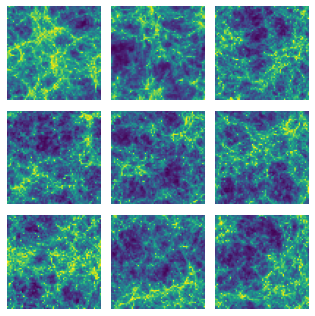

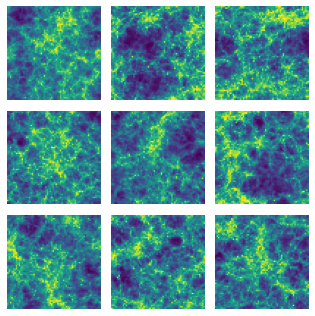

100%|██████████| 13/13 [00:42<00:00,  3.26s/it]


In [147]:
# Sample conditional parameters uniformly for density estimation
M = 40**2

xx, yy = np.meshgrid(np.linspace(pmin[0], pmax[0], num=int(np.sqrt(M))),
                     np.linspace(pmin[1], pmax[1], num=int(np.sqrt(M))))

eval_conds = torch.rand(M, 4)*(pmax[None, 2:] - pmin[None, 2:]) + pmin[None, 2:]
eval_conds = torch.ones_like(eval_conds)*eval_conds.mean(dim=0)[None]
eval_conds = torch.concat([torch.from_numpy(xx.flatten()[:, None]).float(),
                           torch.from_numpy(yy.flatten()[:, None]).float(),
                           eval_conds], dim=1)

save_images(data[ind:ind+9].numpy()[:, 0], title=f'{param_names[0]}={conds[ind][0]:.2f}, {param_names[1]}={conds[ind][1]:.2f}')

c = torch.ones_like(conds[:9, :2])*conds[ind, :2][None]
samp = model.reverse(model.sample_latent(N=9), cond=c).clamp(-1, 1)
save_images(samp.detach().numpy()[:, 0])

batch = 128
logp = []
for i in trange(0, M, batch):
    _, lp = model.forward(img, cond=eval_conds[i:i+batch, :2])
    logp.append(lp)
logp = torch.concat(logp)


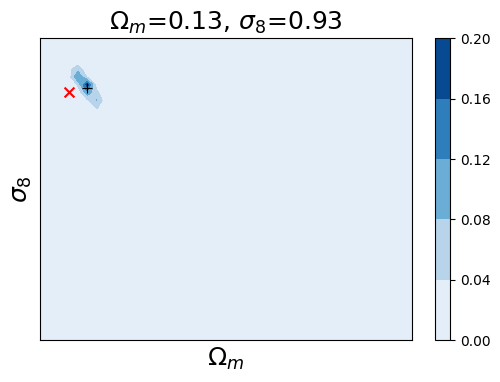

In [148]:
# Show posterior distribution

c = torch.exp(logp - torch.logsumexp(logp, dim=0)).numpy()
m = torch.sum(eval_conds[:, :2]*c[:, None], dim=0).numpy()
c = c.reshape(int(np.sqrt(M)), int(np.sqrt(M)))

fontsize = 18
plt.figure(dpi=100)
plt.contourf(xx, yy, c, levels=5, cmap='Blues', alpha=1)
plt.colorbar()
plt.scatter(conds[ind, 0], conds[ind, 1], 50, 'r', marker='x', linewidths=1.5)
plt.scatter(m[0], m[1], 60, 'k', marker='+', linewidths=.8)
plt.xlabel(f'{param_names[0]}', fontsize=fontsize)
plt.ylabel(f'{param_names[1]}', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
plt.title(f'{param_names[0]}={data_params[ind][0]:.2f}, {param_names[1]}={data_params[ind][1]:.2f}', fontsize=fontsize)
plt.box(True)
plt.grid(False)
plt.show()

In [149]:
# Estimate parameters of 1000 test points
# Sample conditional parameters uniformly for density estimation
M = 40**2

xx, yy = np.meshgrid(np.linspace(pmin[0], pmax[0], num=int(np.sqrt(M))),
                     np.linspace(pmin[1], pmax[1], num=int(np.sqrt(M))))

eval_conds = torch.rand(M, 4)*(pmax[None, 2:] - pmin[None, 2:]) + pmin[None, 2:]
eval_conds = torch.ones_like(eval_conds)*eval_conds.mean(dim=0)[None]
eval_conds = torch.concat([torch.from_numpy(xx.flatten()[:, None]).float(),
                           torch.from_numpy(yy.flatten()[:, None]).float(),
                           eval_conds], dim=1)

# extract test params and images
true_params = data_params[14::15]
imgs = data[14::15]
print(true_params.shape, imgs.shape)

(1000, 6) torch.Size([1000, 1, 64, 64])


In [150]:
# Create samples for the comparison of the marginal p(x) between model and true

num_comp = 500
true = data[np.random.choice(data.shape[0], num_comp)].numpy()[:, 0]
compare_true = data[np.random.choice(data.shape[0], num_comp)].numpy()[:, 0]
alpha = .4
compare_rand = (1-alpha)*compare_true + alpha*2*(np.random.rand(*compare_true.shape)-.5)

auged_samp = int(1.25*num_comp)
c = torch.ones_like(conds[:auged_samp, :2])*conds[np.random.choice(data.shape[0], auged_samp), :2]
samps = model.reverse(model.sample_latent(N=auged_samp), cond=c).clip(-1, 1).numpy()[:, 0]
samps = samps[~np.any(np.isnan(samps), axis=(1, 2))][:num_comp]


/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pk[t]    += FT_box[i,j]*np.conj(FT_box[i,j])
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  pk       /= count # average each bin


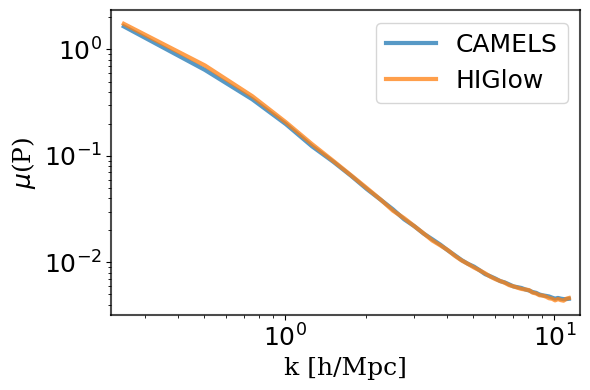

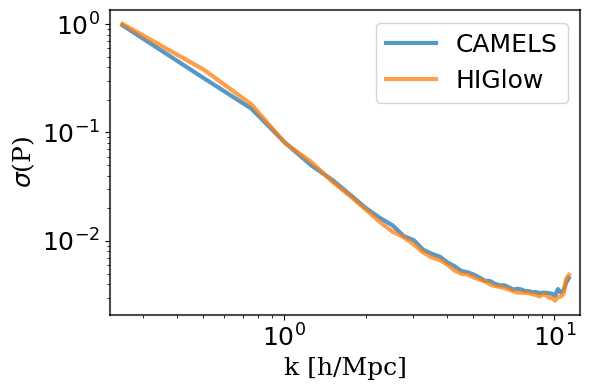

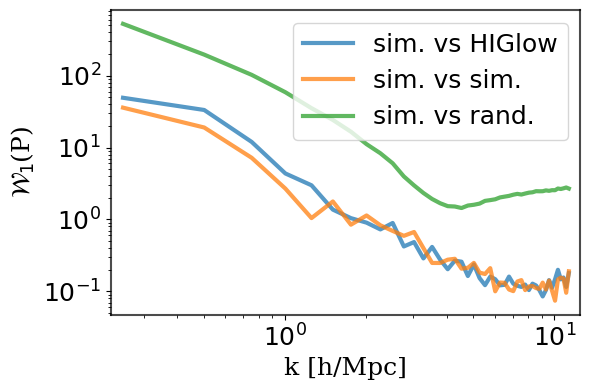

In [151]:
# Compare model to true data

fontsize = 18
compare_spectrums(true, samps,
                  type='mean',
                  loglog=True,
                  fontsize=fontsize)
compare_spectrums(true, samps,
                  type='std',
                  loglog=True,
                  fontsize=fontsize)
compare_spectrums(true, samps,
                  type='w1',
                  loglog=True,
                  fontsize=fontsize,
                  compare_to=[(compare_true, 'sim.'), (compare_rand, 'rand.')]
                  )

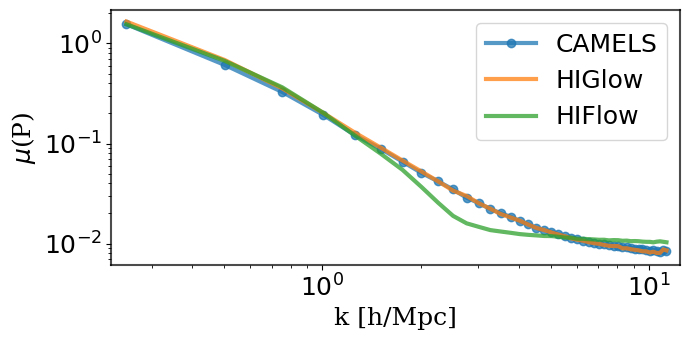

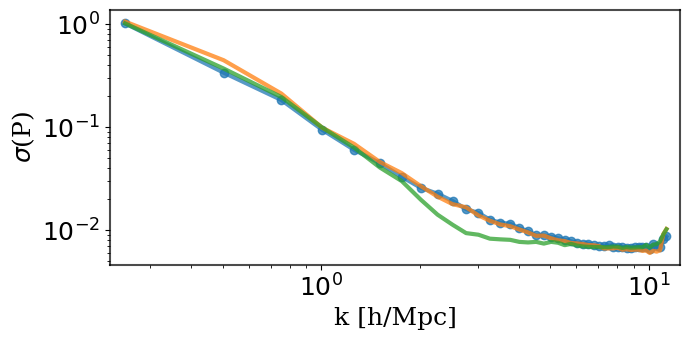

In [152]:
# Compare to HIFlow

def make_plot(plots, ylabel, legend: bool=True):
    font = {'family': 'serif',
            'color': 'black',
            'size': fontsize,
            }
    plt.figure(dpi=100, figsize=(7, 3.5))

    # make plots
    for (plot, label, marker) in plots:
        plt.plot(true_freqs[0], plot, lw=3, alpha=.75, label=label, marker=marker)

    # add frequency label
    plt.xlabel('k [h/Mpc]', fontdict=font)
    plt.ylabel(ylabel, fontdict=font)
    plt.loglog()

    # add labels
    if legend: plt.legend(fontsize=fontsize)

    # further cosmetics
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlim([samp_freqs[0][0]-samp_freqs[0][0]/10,
              samp_freqs[0][~np.isnan(true_pows[0])][-1]+samp_freqs[0][~np.isnan(true_pows[0])][-1]/10])
    plt.tight_layout()

    for spine in plt.gca().spines.values():
        spine.set_linewidth(1.5)
        spine.set_alpha(.7)
    plt.show()


HIFlow = []
with open('HIFlow_results.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for i, row in enumerate(csv_reader):
        if i > 0:
            r = [float(it) for it in row[1:-4]]
            HIFlow.append(r)

HIFlow = np.array(HIFlow)[1:]


true_inv = inv_sigmoid((true + 1)/2)
samp_inv = inv_sigmoid((np.clip(samps, -.999, .999) + 1)/2)

true_freqs, true_pows = power_spectrum(true_inv)
samp_freqs, samp_pows = power_spectrum(samp_inv)

mu_true, mu_samp = np.mean(true_pows, axis=0), np.mean(samp_pows, axis=0)
mu_true, mu_samp = HIFlow[0, 1]*mu_true/mu_true[0], HIFlow[0, 1]*mu_samp/mu_true[0]
plots = [(mu_true, 'CAMELS', 'o'), (mu_samp, 'HIGlow', ''), (HIFlow[:, 1], 'HIFlow', '')]
ylabel = r'$\mu$(P)'
make_plot(plots, ylabel)

sig_true, sig_samp = np.std(true_pows, axis=0), np.std(samp_pows, axis=0)
sig_true, sig_samp = HIFlow[0, 2]*sig_true/sig_true[0], HIFlow[0, 2]*sig_samp/sig_true[0]
plots = [(sig_true, 'CAMELS', 'o'), (sig_samp, 'HIGlow', ''), (HIFlow[:, 2], 'HIFlow', '')]
ylabel = r'$\sigma$(P)'
make_plot(plots, ylabel, legend=False)

15


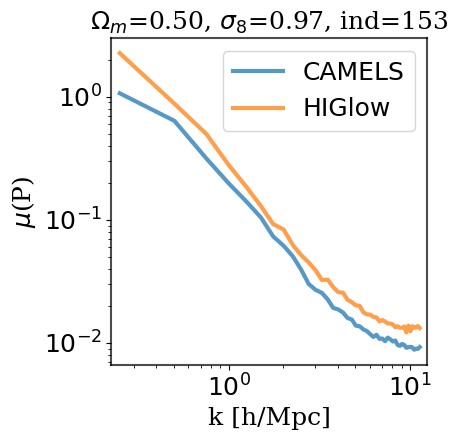

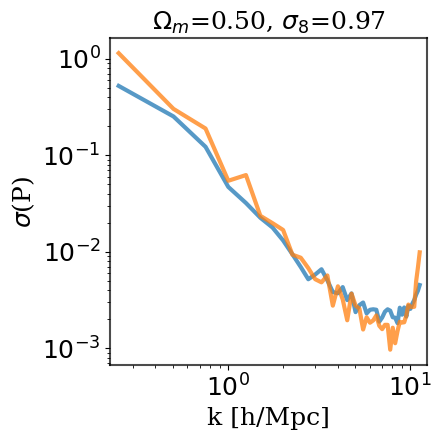

In [165]:
# Compare the power spectrums of conditionaly generated samples

# choose set of indices randomly
np.random.seed(0)
inds = np.random.choice(1000, 5)
inds = [153]
legend = True

for ind in inds:
    c = torch.ones_like(conds[:30, :2])*conds[ind, :2][None]
    val = data_params[ind, :2]
    samps = model.reverse(model.sample_latent(N=30), cond=c).clamp(-1, 1).numpy()[:, 0]
    samps = samps[~np.any(np.isnan(samps), axis=(1,2))][:15]
    print(len(samps))
    true = data[ind:ind+15].numpy()[:, 0]
    compare_spectrums(true, samps,
                      type='mean',
                      loglog=True,
                      title=f'{param_names[0]}={val[0]:.2f}, {param_names[1]}={val[1]:.2f}, ind={ind}',
                      legend=legend, equal=True)
    legend = False
    compare_spectrums(true, samps,
                      type='std',
                      loglog=True,
                      title=f'{param_names[0]}={val[0]:.2f}, {param_names[1]}={val[1]:.2f}',
                      legend=False, equal=True)

In [166]:
# Calculate the R squares for many points in parameter space

inds = np.random.choice(1000, 100, replace=False)

Rs = []
toshow = []
pbar = tqdm(inds)
for ind in pbar:
    c = torch.ones_like(conds[:50, :2])*conds[ind, :2][None]
    val = data_params[ind, :2]
    samps = model.reverse(model.sample_latent(N=50), cond=c).numpy()[:, 0]
    samps = samps[~np.any(np.isnan(samps), axis=(1,2))]
    true = data[ind:ind+15].numpy()[:, 0]

    _, m_true = power_spectrum(true)
    _, m_samp = power_spectrum(samps)
    m_true, m_samp = np.array(m_true), np.array(m_samp)
    m_samp = m_samp[:, ~np.any(np.isnan(m_samp), axis=0)]
    r = R2(np.mean(m_true, axis=0), np.mean(m_samp, axis=0))
    Rs.append(r)
    toshow.append(ind)
    pbar.set_postfix_str(f'Omega={val[0]}, sigma={val[1]}, R2={r:.2f}')

100%|██████████| 100/100 [04:02<00:00,  2.43s/it, Omega=0.1598, sigma=0.7562, R2=0.99]


In [167]:
srt = np.argsort(Rs)
for i in srt:
    print(f'ind {toshow[i]}, R2={Rs[i]}')

ind 641, R2=-0.2818443775627897
ind 252, R2=-0.2765835909942729
ind 298, R2=-0.26043295647725095
ind 299, R2=-0.195092561326226
ind 251, R2=-0.1063192297889346
ind 295, R2=0.2593275813959348
ind 270, R2=0.6928645946313912
ind 267, R2=0.6956613378504695
ind 764, R2=0.7083771326381213
ind 262, R2=0.7526045821044218
ind 522, R2=0.7878882303327203
ind 108, R2=0.8357882796724134
ind 14, R2=0.8396956470465633
ind 272, R2=0.8424773448681265
ind 923, R2=0.8484632529331783
ind 636, R2=0.8545506946843144
ind 765, R2=0.8553404015397208
ind 142, R2=0.8566338483173699
ind 915, R2=0.857352290860176
ind 261, R2=0.8608396503012591
ind 141, R2=0.867777651993079
ind 604, R2=0.8703888437499672
ind 612, R2=0.8726507873138555
ind 939, R2=0.8797291694603904
ind 389, R2=0.8861337139781021
ind 503, R2=0.8876315700371126
ind 45, R2=0.8938145697894776
ind 582, R2=0.8951537638346792
ind 31, R2=0.8975006399732762
ind 858, R2=0.9061198580189607
ind 316, R2=0.9076922651409572
ind 710, R2=0.9082426457416559
ind 264,

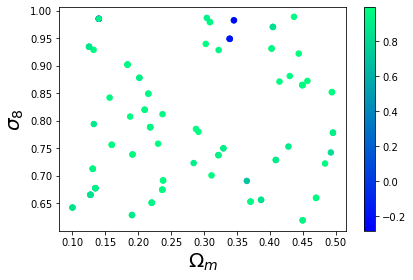

In [168]:
pars = data_params[toshow, :2]
plt.scatter(pars[:, 0], pars[:, 1], 30, c=Rs, cmap='winter')
plt.xlabel(param_names[0], fontsize=20)
plt.ylabel(param_names[1], fontsize=20)
plt.colorbar()
plt.tight_layout()
plt.show()